# Assignment 2

This notebook is the solution to HW2, written by Yaniv Bin and Tair Hakman.

We first would like to import all the required modules in order for our code to run properly:

In [89]:
import os.path
from os.path import abspath, dirname, join
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import collections
import random
import gzip, string, nltk
from nltk.corpus import conll2002
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.naive_bayes import GaussianNB

from sklearn.externals.six.moves import html_parser
from sklearn.externals.six.moves.urllib.request import urlretrieve
from sklearn.datasets import get_data_home
import tarfile
import itertools
from glob import glob
import re
import pandas as pd
from nltk import word_tokenize

## Part 1

Our first task is identifying complex words. In order to do so we will use the data provided. 
first we need to load the data using the provided functions. 
<br>(For a better flow we modified the skeleton code within the notebook, but we added the edit into the skeleton file as well) 

In [2]:
def load_file(data_file):
    words = []
    labels = []   
    with open(data_file, 'rt', encoding="utf8") as f:
        i = 0
        for line in f:
            if i > 0:
                line_split = line[:-1].split("\t")
                words.append(line_split[0].lower())
                labels.append(int(line_split[1]))
            i += 1
    return words, labels

And loading the data:

In [3]:
training_file = abspath(join(dirname("__file__"), "data/complex_words_training.txt"))
development_file = abspath(join(dirname("__file__"), "data/complex_words_development.txt"))
test_file = abspath(join(dirname("__file__"), "data/complex_words_test_unlabeled.txt"))

Now that we have the data we may start working on the actual assignment. 

### Part 1.1 - Evaluation Matrics

Usually in order to evaluate how well a classifcation algorithm works we use three measures - 
- Precision: Measure how 'useful' the results are (how many are hits and how many are miss)
- Recall: Measure how 'complete' the results are (out off all the actually possible results, how many did we hit)
- Fscore: Measure the balance between the Precision and Recall

We would like to implement functions that compose each of these matrics 

We will start by calculating the precision - the precision is defined as:
<br>$precision = \frac{tp}{tp + fp}$
<br>Where $tp$ stands for true-positive meaning a hit, and $fp$ stands for false-positive meaning the prediction is positive but it's actually a false alarm

In [102]:
## Input: y_pred, a list of length n with the predicted labels,
## y_true, a list of length n with the true labels

## Calculates the precision of the predicted labels
def get_precision(y_pred, y_true):
    positive_hits_array = np.array([(1 if(y_pred[i] == y_true[i] == 1) else 0) for i in range(len(y_pred))])
    positive_hits = np.count_nonzero(positive_hits_array == 1)
    total_positive = np.count_nonzero(np.array(y_pred) == 1)
    precision = float(positive_hits) / float(total_positive)
    return precision

In [9]:
y_pred = [0, 1, 1, 0]
y_true = [0, 0, 1, 1]
# Here we have one true positive at position 2, and 1 false positive at position 1
assert(get_precision(y_pred, y_true) == (1/(1+1)))

The second measure we will implement is the recall, calculated as follows
<br>$recall = \frac{tp}{tp + fn}$
<br>Where $fn$ stands for false-negative, meaning the prediction is negative also it should have been positive(a miss).

In [193]:
## Calculates the recall of the predicted labels
def get_recall(y_pred, y_true):
    positive_hits_array = np.array([(1 if(y_pred[i] == y_true[i] == 1) else 0) for i in range(len(y_pred))])
    positive_hits = np.count_nonzero(positive_hits_array == 1)
    false_negative_array = np.array([(1 if ((not(y_pred[i] == y_true[i] )) and (y_pred[i] == 0) ) else 0) for i in range(len(y_pred))])
    false_negative =  np.count_nonzero(false_negative_array)
    recall = float(positive_hits) / float(positive_hits + false_negative)
    return recall

In [194]:
y_pred = [0, 1, 1, 0]
y_true = [1, 0, 1, 1]
# We have one true positive at position 2, and two false negative at positions 0 and 3
assert(get_recall(y_pred, y_true) == (1/(1 + 2)))

and the last measure we want to implement is the fscore(also known as f1) which is calculated as:
<br>$F = 2 * \frac{precision*recall}{precision + recall}$
<br> F score measure the relation between the precision and recall, the results vary between 0 and 1, but once it's equal 1 that means the relation is exact meaning the classifier is perfect. 

In [225]:
## Calculates the f-score of the predicted labels
def get_fscore(y_pred, y_true):
    precision = get_precision(y_pred, y_true)
    recall = get_recall(y_pred, y_true)
    
    # in case we might tr and divide by 0 
    if(precision + recall) == 0:
        return 0
    
    fscore = 2 * float(precision * recall) / float(precision + recall)
    return fscore

In [226]:
y_pred = [0, 1, 1, 0]
y_true = [1, 0, 1, 1]
# precision is 1/2, recall is 1/3
assert(get_fscore(y_pred, y_true) == 2*(((1/2)*(1/3))/(1/2+1/3)))

For our own good we would also like to implement a function that prints out all the information given the two arrays:

In [23]:
def test_predictions(y_pred, y_true):
    print("Precision:", get_precision(y_pred, y_true))
    print("Recall:", get_recall(y_pred, y_true))
    print("Fscore:", get_fscore(y_pred, y_true))

In [24]:
y_pred = [0, 1, 1, 0]
y_true = [1, 0, 1, 1]
test_predictions(y_pred, y_true)

Precision: 0.5
Recall: 0.3333333333333333
Fscore: 0.4


Now after implementing the functions, we can go on and implement actual classifiers. 

### Part 1.2 - Baselines

#### Part 1.2.1 - All complex

The first classifier we will implement is a very simple one that classifies all the words as complex no matter what they actually are.

In [227]:
## Labels every word complex
def all_complex(data_file):
    words, actual_labels = load_file(data_file)
    all_complex_labels = np.ones((len(words),), dtype=int)
    precision = get_precision(all_complex_labels, actual_labels)
    recall = get_recall(all_complex_labels, actual_labels)
    fscore = get_fscore(all_complex_labels, actual_labels)
    performance = [precision, recall, fscore]
    return performance

And we shall test it with each of the files:

In [228]:
ac_tr_precision, ac_tr_recall, ac_tr_fscore = all_complex(training_file)
print("Training Precision: {} \nTraining Recall: {} \nTraining Fscore: {}".format(ac_tr_precision, ac_tr_recall, ac_tr_fscore))

Training Precision: 0.43275 
Training Recall: 1.0 
Training Fscore: 0.604083057058105


In [202]:
ac_dv_precision, ac_dv_recall, ac_dv_fscore = all_complex(development_file)
print("Dev Precision: {} \nDev Recall: {} \nDev Fscore: {}".format(ac_dv_precision, ac_dv_recall, ac_dv_fscore))

Dev Precision: 0.418 
Dev Recall: 1.0 
Dev Fscore: 0.5895627644569816


One can note how the recall of this model is always 1 - that makes sense because although it probably has a lot of false positives - it never "miss" in terms of false negtive because it's always positive. 

#### Part 1.2.2 - word length

The second baseline we will implement is a word length based one, which gives a positive value to a word if it's length goes past a certain threshold.

In [220]:
### 1.2.2: Word length thresholding
def word_length_baseline(data_file, threshold):
    words, actual_labels = load_file(data_file)
    threshold_labels = [(1 if(len(word) >= threshold) else 0) for word in words]
    
    precision = get_precision(threshold_labels, actual_labels)
    recall = get_recall(threshold_labels, actual_labels)
    fscore = get_fscore(threshold_labels, actual_labels)
    preformance = [precision, recall, fscore]
    return preformance

We want to run this for both the training dataset and the development dataset for different threshold values, and plot this:

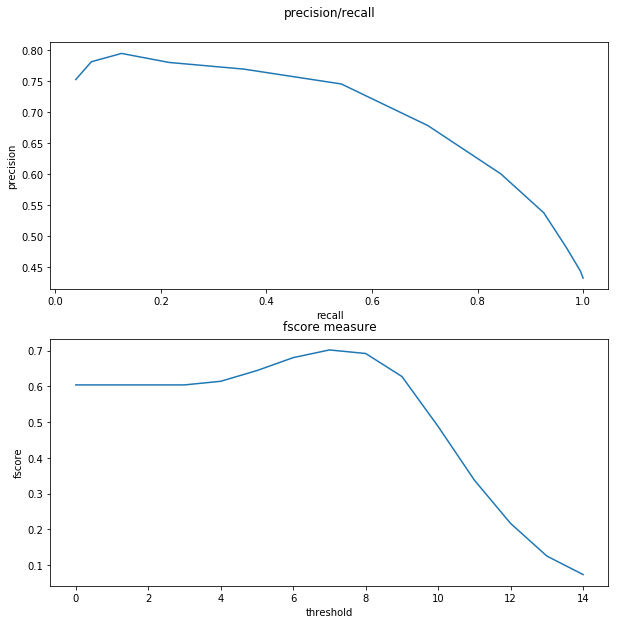

In [221]:
precisions = np.zeros(15)
recall = np.zeros(15)
fscores = np.zeros(15)
for i in range(15):
    tprecision, trecall, tfscore = word_length_baseline(training_file, i)
    precisions[i] = tprecision
    recall[i] = trecall
    fscores[i] = tfscore

plt.figure(num=1, figsize=(10, 10))
pr_plt = plt.subplot(2 ,1, 1, xlabel="recall", ylabel="precision", label="pr")
pr_plt.set_title("precision/recall", y=1.08)
pr_plt.plot(recall, precisions)

fs_plt = plt.subplot(2 ,1, 2, xlabel="threshold", ylabel="fscore", label="fs")
fs_plt.set_title("fscore measure", y=1.01)
fs_plt.plot(range(15), fscores)
plt.show()

We can see that once the recall is big the precision is small and vice versa, that's because the two complement eachother. 

Now we can go about building the "ideal" threshold classifier:

In [222]:
## Finds the best length threshold by f-score, and uses this threshold to
## classify the training and development set
def word_length_threshold(training_file, development_file):
    best_tfscore = 0.0
    best_i = 1
    i = 1
    while(True):
        tprecision, trecall, tfscore = word_length_baseline(training_file, i)
        if(tfscore < best_tfscore):
            print("best threshold is: ", best_i)
            break
        else:
            best_i = i
            i += 1
            best_tfscore = tfscore
            
    tprecision, trecall, tfscore = word_length_baseline(training_file, best_i)
    dprecision, drecall, dfscore = word_length_baseline(development_file, best_i)
    training_performance = [tprecision, trecall, tfscore]
    development_performance = [dprecision, drecall, dfscore]
    return training_performance, development_performance

In [224]:
wl_training_performance, wl_development_performance = word_length_threshold(training_file, development_file)
wl_tr_precision, wl_tr_recall, wl_tr_fscore = wl_training_performance
wl_dv_precision, wl_dv_recall, wl_dv_fscore = wl_development_performance
print("Training Precision: {} \nTraining Recall: {} \nTraining Fscore: {}\n".format(wl_tr_precision, wl_tr_recall, wl_tr_fscore))
print("Dev Precision: {} \nDev Recall: {} \nDev Fscore: {}".format(wl_dv_precision, wl_dv_recall, wl_dv_fscore))

best threshold is:  7
Training Precision: 0.6007401315789473 
Training Recall: 0.8440207972270364 
Training Fscore: 0.7018976699495555

Dev Precision: 0.6053511705685619 
Dev Recall: 0.8660287081339713 
Dev Fscore: 0.7125984251968505


If we look at the threshold to Fscore graph it somewhat fits what we would expect - words that are long (around 6 chars) are usually considered complexed therefore the classifier was right. If we set the threshold too low we'd get a lot of false positives, so the precision will be high, but we will get a bad recall, meaning our classifier is very insensitive and doesn't preform well. If we take a high threshold, not many words will pass it (because there are not many words that are over 8 chars long), so we will get a lot of false negatives. 

#### Part 1.2.3 - Word Frequency 

We now want to implement a method that classifies based on the frequency of a given word in the language, for that we use Google Ngram Counts - so we first have to load it:

In [57]:
### 1.2.3: Word frequency thresholding

## Loads Google NGram counts
def load_ngram_counts(ngram_counts_file): 
    counts = defaultdict(int) 
    with gzip.open(ngram_counts_file, 'rt') as f: 
        for line in f:
            token, count = line.strip().split('\t') 
            if token[0].islower(): 
                counts[token] = int(count) 
    return counts

ngram_path = abspath(join(dirname("__file__"), "data/ngram_counts.txt.gz"))
ngram_counts = load_ngram_counts(ngram_path)

After loading it, we need to explore the ngrams and the text to see what is the range we need for our thresholding.

In [229]:
counter = collections.Counter(ngram_counts)
most_common = counter.most_common(10)
least_common = counter.most_common()[:-10-1:-1]
print("maximal", most_common[0], most_common[1], most_common[2], most_common[5], most_common[9])
print("minimal", least_common[0], least_common[1], least_common[2], least_common[5], least_common[9])

maximal ('the', 47376829651) ('of', 30684794816) ('and', 22042266408) ('a', 14166008316) ('was', 5475451740)
minimal ('tongue-dragging', 0) ('drive-thru', 0) ('two-stage', 0) ('sci-fi', 0) ('already-troubled', 0)


In [301]:
words, actual_labels = load_file(training_file)
counts = []
for i in range(0, len(words)):
    counts.append(ngram_counts[words[i]])
sorted_co = np.sort(np.array(counts))
print("max frequencies", sorted_co[3999], sorted_co[3998], sorted_co[3990], sorted_co[3900])
print("mean %d" % np.mean(sorted_co))
j = 3999
mean = np.mean(sorted_co)
while j > 0:
    if(sorted_co[j] >= mean):
        j -= 1
    else:
        break
print("above mean", 3999 - j)

max frequencies 47376829651 751979946 591878281 225568038
mean 47031121
above mean 828


So we can see the maximal frequency is $47376829651$ and the minimal is $0-40$ so we can use that info for thresholding for the ngrams, but in our training data it's usually around a much lower results, so we need to set a lower bound so we won't keep getting the same prediction all the time, so we went with an upper bout of 225568038 considering there are 100 other frequencies above it.

Now that we have it, we can write a code that use thresholding - if the word count of a certain word is lower than the threshold it gives it 0 and otherwise 1

In [288]:
def word_frequency_baseline(data_file, counts, threshold):
    words, actual_labels = load_file(data_file)
    threshold_labels = [counts[word] < threshold for word in words]
    precision = get_precision(threshold_labels, actual_labels)
    recall = get_recall(threshold_labels, actual_labels)
    fscore = get_fscore(threshold_labels, actual_labels)
    preformance = [precision, recall, fscore]
    return preformance

Now we can test this method using different values for the threshold - We used a range of 40 random numbers between 40 to 225568038 (after examining the Google Ngrams Count) 

thresholds: [  4337946   6925958  20431123  22064713  26308547  27605796  30402978
  35876635  37764242  46162637  47010573  47996835  48617337  52325388
  57765946  62891900  73133850  75069682  78096947  79976290  86708278
  89157423  99976802 114880259 129893105 130366224 136295609 143450524
 156814324 158345298 170868128 182912652 190502095 193381593 194892979
 198955013 216252514 216319901 219620244 220963469]


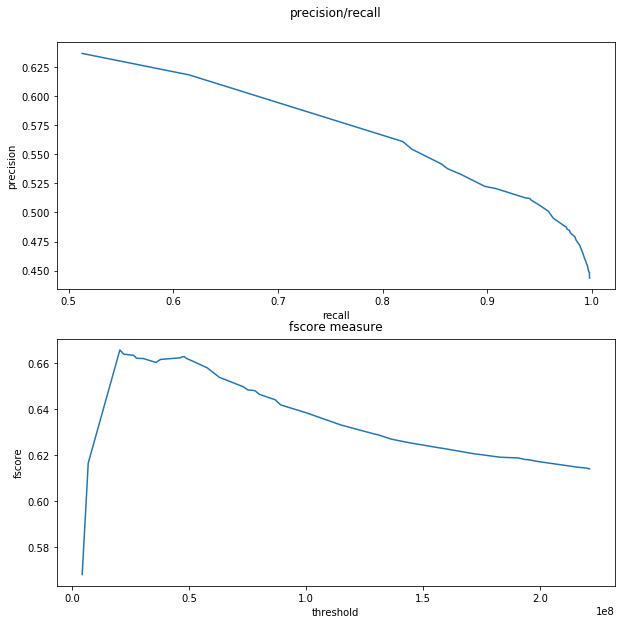

In [289]:
precisions = np.zeros(40)
recall = np.zeros(40)
fscores = np.zeros(40)
thresholds = np.sort(np.random.randint(40, 225568038, size=40, dtype=int))
print("thresholds:", thresholds)
for i in range(40):
    tprecision, trecall, tfscore = word_frequency_baseline(training_file, ngram_counts, thresholds[i])
    precisions[i] = tprecision
    recall[i] = trecall
    fscores[i]=tfscore

    
plt.figure(num=3, figsize=(10, 10))
pr_plt = plt.subplot(2 ,1, 1, xlabel="recall", ylabel="precision", label="pr")
pr_plt.set_title("precision/recall", y=1.08)
pr_plt.plot(recall, precisions)

fs_plt = plt.subplot(2 ,1, 2, xlabel="threshold", ylabel="fscore", label="fs")
fs_plt.set_title("fscore measure", y=1.01)
fs_plt.plot(thresholds, fscores)
plt.show()

We can see (and it makes sense) that the tresholds can vary the recall and precision - a higher recall will be when the threshold is high, and a lower one when it's low and the exact opposite happens with the precision. We do see once we set the threshold lower we get a better fscore - this might be because of the amount of true positives we'd get that way (increases the amount of true positives), if we set it very low it will just act as all positive(which we've seen earlier).

In [292]:
# Finds the best frequency threshold by f-score, and uses this threshold to
## classify the training and development set
def word_frequency_threshold(training_file, development_file, counts):
    best_tfscore = 0.0
    best_threshold = 0
    i = 1
    thresholds = np.sort(np.random.randint(40, 225568038, size=30, dtype=int))
    print("thresholds:", thresholds)
    for threshold in thresholds:
        tprecision, trecall, tfscore = word_frequency_baseline(training_file, counts, threshold)
        if(tfscore > best_tfscore):
            best_tfscore = tfscore
            best_threshold = threshold
    
    print("best threshold", best_threshold)
            
    tprecision, trecall, tfscore = word_frequency_baseline(training_file, counts, best_threshold)
    dprecision, drecall, dfscore = word_frequency_baseline(development_file, counts, best_threshold)
    
    training_performance = [tprecision, trecall, tfscore]
    development_performance = [dprecision, drecall, dfscore]
    return training_performance, development_performance

In [293]:
wf_training_performance, wf_development_performance = word_frequency_threshold(training_file, development_file, ngram_counts)
wf_tr_precision, wf_tr_recall, wf_tr_fscore = wf_training_performance
wf_dv_precision, wf_dv_recall, wf_dv_fscore = wf_development_performance
print("Training Precision: {} \nTraining Recall: {} \nTraining Fscore: {}\n".format(wf_tr_precision, wf_tr_recall, wf_tr_fscore))
print("Dev Precision: {} \nDev Recall: {} \nDev Fscore: {}".format(wf_dv_precision, wf_dv_recall, wf_dv_fscore))

thresholds: [  8076308  16963016  43313047  45500515  52509681  61164096  65620505
  82935725  87474097  92183170 102926018 106003963 110172757 112368609
 118021016 118291486 134768776 140287341 152592017 165116974 170360685
 179289002 181984957 186570419 191729050 197844349 198948871 200912505
 201993290 205896169]
best threshold 16963016
Training Precision: 0.5722689075630252 
Training Recall: 0.7868284228769498 
Training Fscore: 0.6626125030406227

Dev Precision: 0.5642276422764227 
Dev Recall: 0.8301435406698564 
Dev Fscore: 0.6718296224588578


As we can see, this preforms worse than the previous classifier - that might be because although this logic (words that are frequent are usually easier) holds for the real world, it might not hold for our text, we did see the mean of the frequencies in this specific training set is around 47031121 , and there are only 828 words above that mean which is not that many, so there just aren't a lot of very high frequency words in our text.

### Part 1.3 - Classifiers

#### Part 1.3.1 - Naive Bayes Classifier

Now that we've tried different baselines and saw the results from them, that were not that great, it's time to do actual classification.
<br>The method we are going to use is called Naive Bayes Classification.

We personally find that explaining this method via an example makes it a bit easier to grasp instead of just overloading people with probability formulas.
<br>We shall use our example on the given problem considering it is most fitting, and afterwards we will implement the actual code.

We have our dataset which is composed of two types of labels - 0 for a simple word, and 1 for a complex word.
Now lets assume (for the sake of the example, the actual dataset might act differently but we shall see later) someone told us the following - there is a 70% chance of a word being simple, and a 30% chance that a word is complexed.
Another thing they tell you is that the mean of the word length of the simple words is 4 and the mean of word length of the complex words is 7.
<br>Now we got a new word, and it has a length of 3, what will we guess it's label is? Well, an educated guess will be to say there's a big chance it's a simple word...

<br>__How did we assume that?__ We saw there is a high chance of being a simple word, and then we also saw the length of the word is 3 and usually shorter words are simple - so by likelihood the chances of our word being simple are pretty high.
<br>The _Naive Bayse Classifier_ works pretty much just like that.

<br>__How exactly does it work__
<br> First thing to note is that the classifier assumes independence among features, this is not always true in real life (actually, it usually isn't...) but it simplifies the model - in our case it will assume there's no relation between the length of a word and it's frequency (although in reallity it's safe to assume a really long word won't be that frequent). 
Because of how wrong this assumption is, the classifier got the name _naive_.

What the classifier does is to find the probability of belonging to a class, given a set of features, in our case we can write it down as $P(simple | f_{length}, f_{freq})$

Once we have that we can use the Bayse rule to get this probabilty:
<br>$P(simple \vert f_{length}, f_{freq}) = \frac{P(simple) * P(f_{length}, f_{freq} \vert simple)}{P(f_{length}, f_{freq})}$

We already know $P(simple)=0.7$ and we don't need $P(f_{length}, f_{freq})$ to build a classifier, so all we are left to do is calculate $P(f_{length}, f_{freq} \vert simple)$ . 

If we apply the conditional probability formula we will get:
<br>$P(f_{length}, f_{freq} \vert simple) = P(f_{length} \vert simple) * P(f_{freq} \vert simple, f_{length})$
<br><br>Or in the general case (not our example) for $n$ features and a label $l$ we get:
<br>$P(f_1, f_2, f_3, \dots , f_n | l) = P(f_1 \vert l) * P(f_2 \vert l, f_1) * \dots * P(f_n \vert l, f_1, \dots, f_{n-1})$

One can note that if we had n features, this will require a lot of data because we will have to have data for each of these assumption, but we don't actually need it. Why? well, this is where the _naive_ part comes in handy - we assumed all features are independent, so what we actually get is:
<br> $P(f_{length}, f_{freq} | simple) = P(f_{length} \vert simple) * P(f_{freq} \vert simple)$
<br><br>Or in the general case:
<br>$P(f_1, f_2, f_3, \dots , f_n \vert l) = \prod{P(f_i|l)}$

So now finally to classify a new vector of features we have to choose the label for it (simple 0 or complex 1), to do so all we have to do is:
<br>
$Classifier(f_{l'}, f_{f'}) = \arg\max_{s\in{0, 1}}P(f_{l'}, f_{f'} \vert s)$ 
<br><br>Or in the general case for $m$ labels and $n$ features:
<br>
$Classifier(f_{1},\dots, f_{n}) = \arg\max_{s\in{0,\dots,m}}P(f_{1},\dots, f_{n} \vert s)$

__implementation__
<br>So now that we get the reasoning behind this method, we can go along and implement the classifier.
<br>One last thing to note is that we were asked to use the Guassian based classifier, this classifier assumes the features follow a _normal_ distribution (meaning all the features falls on a normal curve).

The following code results in the classifier (note the code comments for a step by step explenation):

In [37]:
### 1.3.1: Naive Bayes
        
## Trains a Naive Bayes classifier using length and frequency features
def naive_bayes(training_file, development_file, counts):
    #import training dataset
    t_words, t_labels = load_file(training_file)
    t_features = {}
    # get length features
    t_features["length"] = np.array([len(word) for word in t_words])
    # get frequency features
    t_features["frequency"] = np.array([counts[word] for word in t_words])
    # build features array
    X_t_original = np.array([t_features["length"], t_features["frequency"]]).T
    
    # normalize features
    t_mean = np.mean(X_t_original)
    t_sd = np.std(X_t_original)
    X_t_scaled = (X_t_original - t_mean)/t_sd
    
    # train the classifier
    clf = GaussianNB()
    clf.fit(X_t_scaled, t_labels)
    
    # extract features for development file
    d_words, d_labels = load_file(development_file)
    d_features = {}
    # get length features
    d_features["length"] = np.array([len(word) for word in d_words])
    # get frequency features
    d_features["frequency"] = np.array([counts[word] for word in d_words])
    # build features array
    X_d_original = np.array([d_features["length"], d_features["frequency"]]).T
    
    # normalize development features - note how we use the training mean and sd
    X_d_scaled = (X_d_original - t_mean)/t_sd
    
    dev_pred = clf.predict(X_d_scaled)
    train_pred = clf.predict(X_t_scaled)
    
    tprecision = get_precision(train_pred, t_labels)
    trecall = get_recall(train_pred, t_labels)
    tfscore = get_fscore(train_pred, t_labels)
    
    dprecision = get_precision(dev_pred, d_labels)
    drecall = get_recall(dev_pred, d_labels)
    dfscore = get_fscore(dev_pred, d_labels)
    
    training_performance = [tprecision, trecall, tfscore]
    development_performance = [dprecision, drecall, dfscore]
    return training_performance, development_performance

In [45]:
nb_training_performance, nb_development_performance = naive_bayes(training_file, development_file, ngram_counts)
nb_tr_precision, nb_tr_recall, nb_tr_fscore = nb_training_performance
nb_dv_precision, nb_dv_recall, nb_dv_fscore = nb_development_performance
print("Training Precision: {} \nTraining Recall: {} \nTraining Fscore: {}\n".format(nb_tr_precision, nb_tr_recall, nb_tr_fscore))
print("Dev Precision: {} \nDev Recall: {} \nDev Fscore: {}".format(nb_dv_precision, nb_dv_recall, nb_dv_fscore))

Training Precision: 0.4853700516351119 
Training Recall: 0.9774696707105719 
Training Fscore: 0.6486486486486487

Dev Precision: 0.4610983981693364 
Dev Recall: 0.9641148325358851 
Dev Fscore: 0.6238390092879257


if we look at the fscore measure in each of the methods we get:

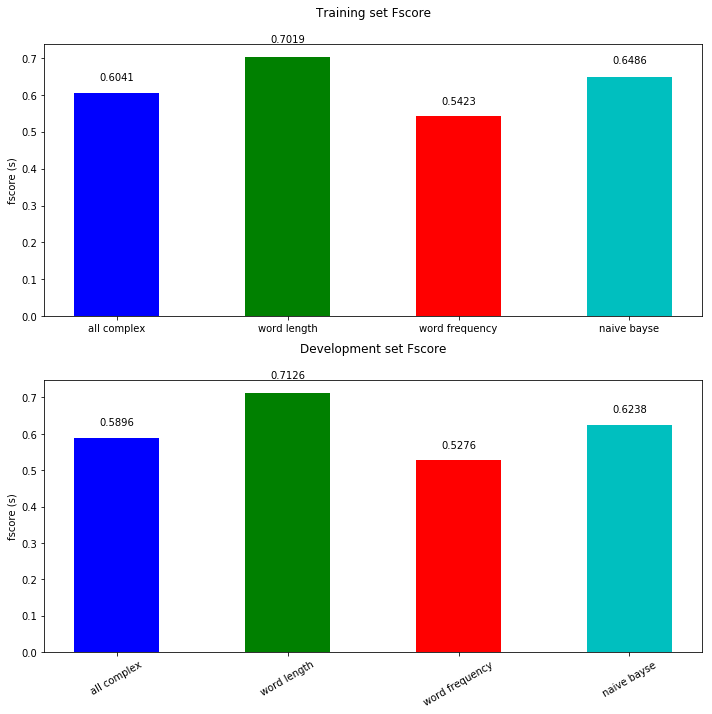

In [191]:
plt.figure(num=5, figsize=(10, 10))
types = ["all complex", "word length","word frequency", "naive bayse"]
f_scores_tr = [ac_tr_fscore, wl_tr_fscore, wf_tr_fscore, nb_tr_fscore]
f_scores_dv = [ac_dv_fscore, wl_dv_fscore, wf_dv_fscore, nb_dv_fscore]
bar_colors = ['b', 'g', 'r', 'c']
ax_tr = plt.subplot(211)
rectangles_tr = plt.bar(range(len(types)), f_scores_tr, width=0.5,
                     color=bar_colors)
ax_tr.set_xticks(np.linspace(0, len(types) - 1, len(types)))
ax_tr.set_xticklabels(types, fontsize=10)
ax_tr.set_ylabel('fscore (s)')
ax_tr.set_title('Training set Fscore', y=1.08)

ax_dv = plt.subplot(212)
rectangles_dv = plt.bar(range(len(types)), f_scores_dv, width=0.5,
                     color=bar_colors)
ax_dv.set_xticks(np.linspace(0, len(types) - 1, len(types)))
ax_dv.set_xticklabels(types, fontsize=10)
ax_dv.set_ylabel('fscore (s)')
ax_dv.set_title('Development set Fscore', y=1.08)


def autolabel(ax, rectangles):
    """attach some text vi autolabel on rectangles."""
    for rect in rectangles:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2.,
                1.05 * height, '%.4f' % height,
                ha='center', va='bottom')
        plt.setp(plt.xticks()[1], rotation=30)


autolabel(ax_tr, rectangles_tr)
autolabel(ax_dv, rectangles_dv)
plt.tight_layout()
plt.show()

As we can see, Naive Bayse does not preform best out of all the classifiers. This might be because of our independence assumption which is really wrong (usually there is a relation between word frequencies and lengths), or because we just didn't choose the right features to work by (as we previously seen, choosing word frequencies as a feature does not preform well). 

As we can see word length preforms the best, that might be because there is actually a really reasonable correlation between the length of a word and how complexed it is.

### Part 1.4 - ambiguity

In some cases the way a words is classified is based on it's context, meaning sometimes a word can be classified as a simple word and sometimes as a difficult word, all because of the context it appeared in. 

We would like to show an example for that - in order to do so, we will find two instances of the same word labeled differently in the training set (the code can easily be adapted to any other set, we chose the training one because it made more sense), then we will explore the context trying to infere why they were tagged differently. 

The first thing we'd like to do is to load the context as well as the words, so we can show how it modifies the classification. In order to do so we need to change the file loading code a bit:

In [ ]:
def load_file_with_context(data_file):
    words = []
    labels = []   
    contexts = []
    with open(data_file, 'rt', encoding="utf8") as f:
        i = 0
        for line in f:
            if i > 0:
                line_split = line[:-1].split("\t")
                words.append(line_split[0].lower())
                labels.append(int(line_split[1]))
                contexts.append(line_split[3])
            i += 1
    return words, labels, contexts

And using the code one the training data we get

In [ ]:
words, labels, contexts = load_file_with_context(training_file)
print(words[0],labels[0],contexts[0])

Now what we need to do is find a words with multiple instances that differ in how it's labeled. 
<br>To do so we will find for each word all it's instances in the words list, and then for words with mulitple labels we will look into the labels to see if they differ, if so we will check the context in which they appear to get a better grasp on why the context matter.

In [ ]:
def find_context_sensitive_words(words, labels, contexts):
    words = np.array(words)
    differences = []
    for word in words:
        ii = np.where(words == word)[0]
        if(len(ii) > 1):
            diff = [(i, j) for i in ii for j in ii if(not labels[i] == labels[j])]
            if(len(diff) > 0):
                # We only have to iterate it half way because the other half is a mirror of the first
                for i in range(int(len(diff)/2)):
                    differences.append((words[diff[i][0]], diff[i][0], diff[i][1]))
    return differences

In [ ]:
ambiguity = find_context_sensitive_words(words, labels, contexts)

And we can show all these words:

In [ ]:
for couple in ambiguity:
    word, index_a, index_b = couple
    print("Word:", word)
    print("Labeled as {} in index {} and as {} in index {}".format(labels[index_a], index_a, labels[index_b], index_b))
    print("First context:\n", contexts[index_a], "\n")
    print( "Second context:\n", contexts[index_b], "\n")

When looking at some of the words one can see how and why they were labeled differently:
- If we look at the word _sprouts_ it appears in two contexts - firstly as a name of a place "Sprouts Farmer" which makes it a very easy identification, but then as a 'sprinkle of sprouts' which is much more complexed (especially if like us you're not a native English speaker and had to google 'sprouts')
- If we look at the word _element_ , seemengly a simple word, it can come as an actual element like in the first context("the heaviest element") but it can also appear in as a slang word - "in his element" like in the second context, which complicate things. 

## Part 2

### Part 2.1

___Remark___ : We did now want to load the entire notebook as part of our notebook because that will just be overloading on our notebook, but we do want to touch upon required information so we imported the methods we need from the original notebook and implemented methods to fit the requirements of our question.

The first thing we want to do is to explore the dataset they used for the classifiers implementation. In order to do that we will first have to load the dataset(note that we used the code they implemented to do so, but we modified it for our need)

In [ ]:
class ReutersParser(html_parser.HTMLParser):
    """Utility class to parse a SGML file and yield documents one at a time."""

    def __init__(self, encoding='latin-1'):
        html_parser.HTMLParser.__init__(self)
        self._reset()
        self.encoding = encoding

    def handle_starttag(self, tag, attrs):
        method = 'start_' + tag
        getattr(self, method, lambda x: None)(attrs)

    def handle_endtag(self, tag):
        method = 'end_' + tag
        getattr(self, method, lambda: None)()

    def _reset(self):
        self.in_title = 0
        self.in_body = 0
        self.in_topics = 0
        self.in_topic_d = 0
        self.title = ""
        self.body = ""
        self.topics = []
        self.topic_d = ""

    def parse(self, fd):
        self.docs = []
        for chunk in fd:
            self.feed(chunk.decode(self.encoding))
            for doc in self.docs:
                yield doc
            self.docs = []
        self.close()

    def handle_data(self, data):
        if self.in_body:
            self.body += data
        elif self.in_title:
            self.title += data
        elif self.in_topic_d:
            self.topic_d += data

    def start_reuters(self, attributes):
        pass

    def end_reuters(self):
        self.body = re.sub(r'\s+', r' ', self.body)
        self.docs.append({'title': self.title,
                          'body': self.body,
                          'topics': self.topics})
        self._reset()

    def start_title(self, attributes):
        self.in_title = 1

    def end_title(self):
        self.in_title = 0

    def start_body(self, attributes):
        self.in_body = 1

    def end_body(self):
        self.in_body = 0

    def start_topics(self, attributes):
        self.in_topics = 1

    def end_topics(self):
        self.in_topics = 0

    def start_d(self, attributes):
        self.in_topic_d = 1

    def end_d(self):
        self.in_topic_d = 0
        self.topics.append(self.topic_d)
        self.topic_d = ""


def stream_reuters_documents(data_path=None):
    DOWNLOAD_URL = ('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                        'reuters21578-mld/reuters21578.tar.gz')
    ARCHIVE_FILENAME = 'reuters21578.tar.gz'
    data_path = os.path.join(get_data_home(), "reuters")
    if not os.path.exists(data_path):
        """Download the dataset."""
        print("downloading dataset (once and for all) into %s" %
              data_path)
        os.mkdir(data_path)

        def progress(blocknum, bs, size):
            total_sz_mb = '%.2f MB' % (size / 1e6)
            current_sz_mb = '%.2f MB' % ((blocknum * bs) / 1e6)
            if _not_in_sphinx():
                sys.stdout.write(
                    '\rdownloaded %s / %s' % (current_sz_mb, total_sz_mb))

        archive_path = os.path.join(data_path, ARCHIVE_FILENAME)
        urlretrieve(DOWNLOAD_URL, filename=archive_path,
                    reporthook=progress)

        print("untarring Reuters dataset...")
        tarfile.open(archive_path, 'r:gz').extractall(data_path)
        print("done.")
          
    parser = ReutersParser()
    doc_counter = 0
    docs = {
        'title_index': [],
        'title': [],
        'body': [],
        'topic': []
    }
    for filename in glob(os.path.join(data_path, "*.sgm")):
        for doc in parser.parse(open(filename, 'rb')):
            if(doc['topics']):
                for topic in doc['topics']:
                    docs['title_index'].append(doc_counter)
                    docs['title'].append(doc['title'])
                    docs['body'].append(doc['body'])
                    docs['topic'].append(topic)
            else:
                docs['title_index'].append(doc_counter)
                docs['title'].append(doc['title'])
                docs['body'].append(doc['body'])
                docs['topic'].append(None)
            doc_counter += 1
    return docs

What we did is to modify the downloader function to return a dictionary of the form 'title','body', 'topic' which we then can feed into the Pandas dataframe module and explore it.
Note how we arranged it by topics so it will be easier to handle for our needs. 

In [ ]:
data_stream = stream_reuters_documents()

In [ ]:
df = pd.DataFrame(data=data_stream)
print("there are {} topics in the dataset".format(df.topic.nunique()))
print("and {} unique titles".format(df.title.nunique()))
print("there are {} documents in the dataset".format(df.title_index.nunique()))

Now for each of the topics we can get the count, mean, max index, std, and so on:

In [ ]:
print(df.groupby('topic').describe())

After exploring the dataset in terms of the documents it contains and the topics they are about, we want to explore the dataset content in terms of words.

In [ ]:
def report_vocab_statistics(dataframe):    
    print("statistics about the characters in each of the document's body:\n")
    print(dataframe['body_length_chars'].describe(), "\n")
    
    print("statistics about the words in each of the document's body:\n")    
    print(dataframe['body_length_words'].describe(), "\n")
    
    print("total amount of words in all the documents(body): {}\n".format(dataframe['body_length_words'].sum()))
    print("total amount of characters in all the documents(body): {}\n".format(dataframe['body_length_chars'].sum()))    

In [ ]:
#we first want to modify the dataframe to have all the required fields for the statistics
mod = df.drop(['topic'], axis=1)
mod = mod.drop_duplicates(subset=['title_index'], keep='first')
mod['body_length_chars'] = mod['body'].map(lambda x: len(x))
mod['body_length_words'] = mod['body'].map(lambda x: len(word_tokenize(x)))    

In [ ]:
report_vocab_statistics(mod)

After reporting and gathering all the information regarding the dataset, it is time for us to start analyzing the code and what's going on in it.

The main principle the author of the code is trying to show is the idea of 'out of core' learning.

__What is out of core learning?__ 
<br>Sometimes, especially when dealing with text documents, the dataset we get to work with is much greater than the actual RAM we have on a decent computer, so we wouldn't want to load all of it in one go (that will just result in our computer slowing down until it can't go on...)

The idea of out of core learning is this - we will load a certain amount of data each time and learn from it (batches), so generally speaking, most of our learning is done from things we don't hold in our memory anymore (therfore out of core).

To do so, Scikit-learn implemented an API called "partial_fit" - a classifier that implements a partial fit works as follows: 
<br>The classifier will see a batch and then will incremently update whatever it is learning based on that batch, that way whenever a new batch arrives it learns what it needs from it and "throws it away" instead of holding it in memory or trying to learn everything in one go. 

For example, as we've seen just now the dataset we work with has over $2000000$ words, that is a very large dataset to work with in one batch (for example, in the last assignment we only had $978726$ and that took a while to process as well...), 
so to try and infere information from it, let alone actual learning, is a nearly impossible task if you use a regular computer. What we should do instead is 'chunk' the dataset (in the notebook they used a 1000 documents each time, and considering there are $21578$ documents, it means $\frac{2854659}{21578} = 132.3$ (approx) words per document, so we only work with $132300$ words each time which is much more reasonable.

The formal name for the learning process we just discussed is called _online setting_ - lets farther explain it (we'll focus on classification, but there are also online settings for regression problems).
<br>On each round we receive an instance $x_t$ and extend a prediction using our current hypothesis $w_t$(we estimate weights). 
We then receive the true target $y_t$ and suffer an instantaneous loss based on the discrepancy between $y_t$ and our prediction.
<br>Our goal is to make the cumulative loss that we suffer small.
Finally, we update the hypothesis according to the previous hypothesis and the current example.


Even more formally - we can describe this using math as follows:

- Given $x_t \in R^n$ , we predict $sign(w_t * x_t)$
- We get the true target and suffer loss - $\max({\epsilon - y_{t}w_{t}*x_{t}})$
- We update the hypothesis - $w_{t+1} = g(w_t, z_t)$

Usually in classification $z_t$ is set to be the distance between our results and the true prediction. 

The code they implemented test and compare a few classifiers that implement a partial fit:

-  ___SGD___ - SGD stands for Stochastic Gradient Descent. This methood is really similar to the Gradient Desecent method we discussed in class, only this time it is stochastics, meaning the samples are selected randomly. Each sample at a time the gradient of the loss is estimated and the model is updated with a learning rate. Just like regular gradient descent we optimize $w$ by minimizing the loss function. In the begining we choose an initial guess for $w$ and a learning rate $\eta$, we then randomly shuffle the examples in the training set, and then for each sample we update $w$ to be  $w = w - \eta \nabla Q_i(w)$ , we keep doing so until the algorithm converge. 

-  ___Perceptron___ - this is an algorithm for supervised learning of a binary classifier (a classifier which determines if an inputed represented by a vector of numbers fits a class or doesn't). the algorithm is based on a linear-predictor function, which is a function of the form $g(x) = wx + b$ where $x$ is our input, $w$ is a set of weights, and $b$ is the bias. what the perceptron does if to return $1$ if $g(x) > 0$ and $0$ otherwise. The algorithm learns the set of weights(tunes the weights) based on the training data, and then once it has them and it gets a vector x from the test data it feeds it to the function $g$ with the learned weights.

-  ___NB Multinomial___ - Naive Bayes Multinomial Classifier is a Naive Bayes Classifier (see Part 1 of the assignment for  explenation) for multinomial models, that means that the feature vectors represent the frequencies with which certain events have been generated by a multinomial with probabilities $p_1, \dots, p_n$ such that $p_i$ is the probability that event $i$ occures. A feature vector in this model is therefor a histogram with $x_i$ counting the number of times event i was observed in a particular instance. In document classification this  classifier is usually used with events representing the occurrence of a word in a single document (aka bag-of-words). 

-  ___Passive-Aggressive___ - this type of classifier uses a measure called _hinge-loss_ in it's training process. The hinge loss is defined as 
<br>$\ell(w; (x,y)) = \max(0, \delta(w,(x,y))-\epsilon)$
<br> where $\delta(w,(x,y))$ is the distance between $y$ and $xw$ : $\delta(w,(x,y)) = |y_t-(x_{t}w_{t}|$
<br> and $\epsilon$ is the insensitivity parameter.
<br> The algorithm goal is to make the hinge loss as small as possible at each round.
<br> On each round of the algorithm we update the weights based on -
<br> $w_{t+1} = \arg\min_{w \in R^n} \frac{||w-w_t||^2}{2} \\ s.t \\ \ell(w; (x_t,y_t)) = 0$
<br> Which is basically a projection of $w_t$ on the space of vectors that has a 0 loss.
<br> This algorithm is _passive_ when the hinge loss is 0, because then we get $w_{t+1} = w_t$, but it's _aggressive_ when that's not the case, because when it's not 0 it aggressively forces $\ell(w_{t+1}; (x_t,y_t)) = 0$

After explaining each of the Algorithms we only have one thing to address - the _hashing-vectorized_.
<br>The method converts a collection of documents into a matrix of token occurences, and it uses scipy sparse matrix (which means that, considering this probably is a very sparse matrix, all the values that are assigned 0 are not kept in memory). The idea in this implementation is to use hashing to find the token string name to feature integer index mapping.
<br>We need to use this method here for a few reasons:
- It is very low in memory, we don't need to store an entire dictionary in memory. 
- There is no state computed during fit (in partial fit). 
- It holds no state besides the constructor parameters. 

As we note in the code, they used this method with $n_{features} = 2^{18}$, that is because if they don't do so, there might be collisions (different tokens mapped to same place).

## Part 3

In this task, we will create a NER (Named Entity Recognition) model that recognizes names of persons, organizations and other entities in text. We will use the CoNLL 2002 dataset. As we build the code, we will use the Spanish version of the dataset. At the end of every segment, we'll test our functions on the Dutch dataset and compare the differences. 
First, we will import the data:

In [ ]:
train_sents = list(conll2002.iob_sents('esp.train'))
test_sents = list(conll2002.iob_sents('esp.testa'))
d_train_sents = list(conll2002.iob_sents('ned.train'))
d_test_sents = list(conll2002.iob_sents('ned.testa'))

Let's understand how our dataset is represented. Each of the two datasets is imported as a list. Each element in the list is a **sentence**. Let's look at an example of the first element (and hence, first sentence) in the first dataset: 

In [ ]:
train_sents[0]

As we can see, the sentence represented by a list of word. A word is **also** represented by a list, that contains three elements: the word itself, it's POS (Part of Speech) tagging, and it's correct NER tagging. 

Now that we understand our data, it's time to extract features. We'll be looking for word level features, and in this step we'll be looking at each word separately. Those are the features we've chosen to extract for every word:

Form (The actual word), POS tagging, is number, does it contain a number, does it begin with a capital letter, is it all capital letters, is it a punctuation char, the first one, two and three letters of the word, the last one, two and three letters in of the word. 
Here's the code for feature extraction:

In [ ]:
def hasNumbers(str):
    return any(c.isdigit() for c in str)

def get_word_features (word):
    w = word[0]
    features = {
     "form": w,
     "pos": word[1],
     "is_number": w.isdigit(),
     "contains_number": hasNumbers(w),
     "beginCapital": w[0].isupper(),
     "allCaps": w.isupper(),
     "isPunc": w in string.punctuation,
     "firstLetter": w[0],
     "first2Letters": w[0:2],
     "first3Letters": w[0:3],
     "lastLetter": w[-1],
     "last2Letters": w[-2:],
     "last3Letters": w[-3:]
    }
    return features

And here's an example on the word 'Melbourne':

In [ ]:
get_word_features(train_sents[0][0])

So now we have our features, it's time to train our model. We will be using Scikit's DictVectorizer data structure to keep our data, and it's logistic regression implementation for the training. Those methods requires two seperate lists of identical size, where every element represents one word in the corpus. The first list (X) keeps the list of features for every word, and the second list (y) has the NER tagging of the word - which is the answer our model will be trying to guess.

Here is the code that creates those lists:

In [ ]:
def get_corpus_features (corpus):
#gets a corpus, returns a list of features for every word
    X=[]
    for sent in corpus:
        X+=[get_word_features(w) for w in sent]
    return X

def get_y (corpus):
    y=[]
    for sent in corpus:
        y+=[w[2] for w in sent]
    return y

Note that, in addition to the obvious effect of getting features/NER taggings, those functions also transform our data from a list of **sentences** to a list of **words** - so our output is a big list of all the words, not divided to sentences anymore.

Now we'll create our DictVectorizer and train our model:

In [ ]:
def train(train_sents, v, features):
    y = get_y (train_sents)
    X = v.fit_transform(features)
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X, y)
    return clf

v = DictVectorizer(sparse=True)
features = get_corpus_features(train_sents)
clf = train(train_sents, v, features)

The **DictVecotizer** structure and it's fit_transform method, transforms the features list to a matrix. Each row in the matrix represents a word, and each column represents a feature. Each cell M(i,j) includes the corresponding numerical value for feature j in word i.
But what if the features are non-numerical? Boolean data easily transforms to 1 (True) or 0 (False), but strings are a bit more complicated to encode. DictVectorizer's solution is to create a separate boolean feature for every string it encounters. For example, for the word "Melbourne", rather than the "firstLetter" feature, it will create a new boolean feature: "firstLetter=M", that will be True for every word that begins in M, and False otherwise.

This is a good solution, but it means that each word, prefix or suffix of length 1,2,3, and other string features - a specific feature will be created. In othe words, our matrix is getting really big. For the first sentence alone (11 words), 75 features are created. For the entire dataset (264715 words), the matrix will be huge - in fact, too huge for the computer's memory (or at least, *my* computer's memory) to handle.

That's why we use a **sparse** version of the matrix. The sparse data structure takes advantage of the fact that most of the matrix (typically above 99%) is zeros - the word "Melbourne" for example will have 0 in every prefix feature other than "firstLetter=M", "first2Letters=Me" and "first3Letters=Mel" (same applies for suffix). So the sparse data structre, rather than actually save all those zeros, only keeps the non-zero values and cells, and assumes zero everywhere else.

So now we have our sparse matrix X, and our target values y, it's time to create our classifier (clf) using Scikit's logistic regression implementation. It's time to test this model on the our test set:

In [ ]:
def predict (clf, v, test_features):
    X2 = v.transform(test_features)
    return clf.predict(X2)

test_features = get_corpus_features(test_sents)
y_predict = predict (clf, v, test_features)
y_true = get_y (test_sents)

This function is fairly straight forward, but it's interesting to note the *transform* method used. We create a sparse feature matrix for the test set, but it will not be in the same size as the original matrix for the train data. However, the *predict* method demands that the train and test matrixes will have the same number of features. 
The transform method transforms the test_features matrix to the same size as the train_features - by adding empty columns for features encountered in the training data, but not the test data. However, this also means there's some information loss - as features that were encountered in the test data but not the train data are "silently ignored".

So now we have our predictions, it's time to evaluate how well we did. We can do this by several different methods. The easiest of which will be to calculate the accuracy score:

In [ ]:
def accuracy (x,y):
    correct = sum([1 if x[i]==y[i] else 0 for i in range(len(x))])
    return correct / len(x)

accuracy(y_predict, y_true)

So almost 93%, not too bad but we will try to do better. We also have more tools to analyze our errors. For a start, we can simply print all the errors and manually look at them:

In [ ]:
def get_errors (x,y,test_sents):
    features = get_corpus_features(test_sents)
    errors=[]
    for i in range(len(x)):
        if x[i]!=y[i]:
            errors.append((y[i], x[i], features[i].get("form")))
    return sorted(errors)
        
errors = get_errors (y_predict,y_true,test_sents)
for i in range(20):
    print('correct=%-8s guess=%-8s word=%-30s' % (errors[i][0],errors[i][1],errors[i][2]))
    
#we only print the first 20 errors as examples

We can also take a look at the confusion matrix:
(We'll also print the NER tags in order, because the Scikit confusion matrix does not include labels).

In [ ]:
print (set(y_true))
print (metrics.confusion_matrix(y_true, y_predict))

Scikit also offers an handy tool called a classification report:

In [ ]:
print(metrics.classification_report(y_true, y_predict))

It seems we are doing a very good job with recognizing O's, but we struggle with other tags. In general, B tags seem to have better score than I tags, while MISC category seems to be the most difficult to classify. It also means that our 93% accuracy score is misleading - the score is relatively high because we are good in recognizing O's (which is the majority of the dataset), but when it comes to the classification of other tags, our accuracy is much lower.

Let's check our model on the Dutch dataset as well:

In [ ]:
d_features = get_corpus_features(d_train_sents)
d_clf = train(d_train_sents, v, d_features)
d_test_features = get_corpus_features(d_test_sents)
d_y_predict = predict (d_clf, v, d_test_features)
d_y_true = get_y (d_test_sents)
print ("accuracy:", accuracy (d_y_predict,d_y_true))
print (metrics.classification_report(d_y_true, d_y_predict))

It seems our Dutch model is doing slightly better than the Spanish one, but it's still prone to similar mistakes - once again we recognize very high success rates among O's (which are the big majority of the dataset), I tags are more difficult to predict than B tags, and "Misc" category is still problematic. 
One noticeable difference is that the Dutch model seems to struggle with Location names (0.29 fscore on I-LOC - even lower than I-MISC), which the Spanish model did better on. A possible explanation is insufficient training data - the Dutch dataset only had 64 I-LOC tags, which is much lower than other tags. 
The support column refers to the test dataset and not the training dataset, but a check on the training dataset confirms that I-LOC tags are indeed relatively rare.

So now, we will try to imrove our overall model by using more than just word-specific features - we'll be looking at features of the previous and following word. Here's our updated *get_word_features2* method, which now receives three arguments (the previous and next word, in addition to the current one) and extracts all features for all 3 words: 

In [ ]:
def get_word_features2 (word, prev, next):
#also includes information about next and previous word
    w = word[0]
    p = prev[0]
    n = next[0]
    features = {
     "form": w,
     "pos": word[1],
     "is_number": w.isdigit(),
     "contains_number": hasNumbers(w),
     "beginCapital": w[0].isupper(),
     "allCaps": w.isupper(),
     "isPunc": w in string.punctuation,
     "firstLetter": w[0],
     "first2Letters": w[0:2],
     "first3Letters": w[0:3],
     "lastLetter": w[-1],
     "last2Letters": w[-2:],
     "last3Letters": w[-3:],
     "p_form": p,
     "p_pos": prev[1],
     "p_is_number": p.isdigit(),
     "p_contains_number": hasNumbers(p),
     "p_beginCapital": p[0].isupper(),
     "p_allCaps": p.isupper(),
     "p_isPunc": p in string.punctuation,
     "p_firstLetter": p[0],
     "p_first2Letters": p[0:2],
     "p_first3Letters": p[0:3],
     "p_lastLetter": p[-1],
     "p_last2Letters": p[-2:],
     "p_last3Letters": p[-3:],
     "n_form": n,
     "n_pos": next[1],
     "n_is_number": n.isdigit(),
     "n_contains_number": hasNumbers(n),
     "n_beginCapital": n[0].isupper(),
     "n_allCaps": n.isupper(),
     "n_ispunc": n in string.punctuation,
     "n_firstLetter": n[0],
     "n_first2Letters": n[0:2],
     "n_first3Letters": n[0:3],
     "n_lastLetter": n[-1],
     "n_last2Letters": n[-2:],
     "n_last3Letters": n[-3:]
    }
    return features

def get_corpus_features2 (corpus):
#gets a corpus, returns a list of features for every word
    flat = [w for sent in corpus for w in sent]
    pad = [("*","*","*")]
    flat = pad + flat + pad
    X=[]
    for i in range(1, len(flat)-1):
        X.append(get_word_features2(flat[i],flat[i-1],flat[i+1]))
    return X

So now let's train on the new data, and try to predict and check our new accuracy score:

In [ ]:
features2 = get_corpus_features2(train_sents)
clf2 = train(train_sents, v, features2)
test_features2 = get_corpus_features2(test_sents)
y_predict2 = predict (clf2, v, test_features2)
y_true2 = get_y (test_sents)
print ("accuracy:", accuracy (y_predict2,y_true2))
print (metrics.classification_report(y_true2, y_predict2))

So the new score is around 95% - an improvement on the previous attempt. Let's check on the Dutch dataset:

In [ ]:
d_features2 = get_corpus_features2(d_train_sents)
d_clf2 = train(d_train_sents, v, d_features2)
d_test_features2 = get_corpus_features2(d_test_sents)
d_y_predict2 = predict (d_clf2, v, d_test_features2)
d_y_true2 = get_y (d_test_sents)
print ("accuracy:", accuracy (d_y_predict2, d_y_true2))
print (metrics.classification_report(d_y_true2, d_y_predict2))

We see a similar improvement in the Dutch model as well - who is now up to almost 97% accuracy score. We see some improvement in all categories, including the problematic ones. I-LOC for example is up from 0.29 to 0.41, which is an improvement but still not a good score by any means.

#### Part 3.1.3 - Finding Illegal Sequences

So far, the tagging method we used was greedy tagging. We did not check the logic of the tagging, and in particular we didn't check if tag sequences were legal or not. Let's write a function that will find all illegal tag sequences:

In [ ]:
def find_illegal_sequences (guess):
    OIX, IXIY, BXIY = 0,0,0
    for i in range(len(guess)-1):
        curr, next = guess[i], guess[i+1]
        if curr[0]=="O" and next[0]=="I":
            OIX+=1
        elif curr[0]=="I" and next[0]=="I" and curr[1:] != next[1:]:
            IXIY+=1
        elif curr[0]=="B" and next[0]=="I" and curr[1:] != next[1:]:
            BXIY+=1
    return {"O-IX": OIX, "IX-IY": IXIY, "BX-IY": BXIY}

print ("Spanish:", find_illegal_sequences(y_predict2))
print ("Dutch:", find_illegal_sequences(d_y_predict2))

In the Spanish dataset, all three illegal sequences seem to happen in similar frequency. Our test set includes 52923 words (and hence 52922 sequences of 2), and overall we guessed 646 illegal sequences - that's about 1.2% of our guesses. 
In the Dutch dataset, illegal sequences are rarer, and only take about 0.5% of our guesses (which is consistent with our results so far, in which our model did better in Dutch than Spanish).

How can we use this information?
If we were to change our predicting model to prevent it from predicting illegal sequences, we could theoretically improve our accuracy by **up to** 1.2%. Of course, this will be a difficult process. Even if we know that a sequence of 2 tags is illegal, we still face two problems:

-We need to determine which of the two tags is wrong (or maybe both are wrong)
-We need to correct it to the right answer.

If we were to implement such an algorithm, a possible method of doing so would be to use the *predcit_proba* method, which for every word, returns the probability of each tag (a distribution). Using this method, a possible rough algorithm would be:

-Predict normally

-Look for illegal sequences - similar to *find_illegal_sequences* above, but rather than just counting, for every illegal sequence we find we will perform the following steps:

-Determine which of the two tags is more likely to be wrong. We can do it by getting max probability in each word's distribution, and choosing the lower value of the two. 
For example: let w1,w2 be two words, and t1,t2 the tags with the highest probability. If p(t1)>p(t2), we will conclude that ws is more likely to be wrong.

-Look for the second highest probability in w2's distribution - let's call it t2'. 

-Check if the sequence (t1, t2') is a legal sequence. If it is, change w2 tag to t2' and move to the next sequence.

-If it's illegal, we'll try the next most likely tag - it might be the next option on w2's distribution, or the second option in w1's distribution. 

-Repeat until you get a legal sequence.
